This notebook shows how load a normalizing flow into a Creator object, and draw samples of galaxy redshifts, magnitudes, and conditional pdf's.

In [1]:
from creator import Creator
from normalizingFlow import NormalizingFlow
from rqNeuralSplineFlow import RQNeuralSplineFlow

First, load the generator, which in this case will be the normalizing flow created in `redshift_flow_example.ipynb`

In [2]:
# load the generator
flow = NormalizingFlow(RQNeuralSplineFlow, file='demo_flow.pkl')

In [3]:
# instantiate the creator
creator = Creator(flow)

Now let's draw 10k samples from the flow

In [5]:
%%time 
# draw the samples
samples = creator.sample(10000, include_pdf=False, seed=0)

CPU times: user 6.9 s, sys: 348 ms, total: 7.25 s
Wall time: 5.41 s


In [6]:
# print the first few
samples.head()

,redshift,u,g,r,i,z,y
0,0.327615,27.492502,26.766901,26.051714,25.851719,25.649448,25.623770
1,0.266856,26.542746,25.686508,25.097267,24.862265,24.765139,24.650902
2,1.278494,27.811972,26.956390,26.151596,25.453327,24.810278,24.229086
3,0.801114,28.586660,27.630808,26.048927,24.761028,24.278296,24.020912
4,0.637461,23.747169,23.281570,22.459063,21.852486,21.710953,21.542067


In [7]:
# get size of the samples
nMB = samples.memory_usage(index=True).sum()/1e6
print(f'size of samples in memory is {nMB:.3f} MB')

size of samples in memory is 0.280 MB


Let's draw the same sample, but this time get the conditional pdf's as well.

In [8]:
%%time
# draw the samples and include pdf's
samples_wPDF = creator.sample(10000, include_pdf=True, seed=0)

CPU times: user 11min 58s, sys: 8min 1s, total: 19min 59s
Wall time: 3min 48s


In [9]:
# print the first few
samples_wPDF.head()

,redshift,u,g,r,i,z,y,pdf
0,0.327615,27.492502,26.766901,26.051714,25.851719,25.649448,25.623770,"[5.4386523e-10, 1.5797336e-09, 4.789546e-09, 1..."
1,0.266856,26.542746,25.686508,25.097267,24.862265,24.765139,24.650902,"[2.1184915e-06, 6.1883093e-06, 1.9478091e-05, ..."
2,1.278494,27.811972,26.956390,26.151596,25.453327,24.810278,24.229086,"[5.746411e-10, 7.598325e-10, 1.0227392e-09, 1...."
3,0.801114,28.586660,27.630808,26.048927,24.761028,24.278296,24.020912,"[1.7290624e-12, 2.2334196e-12, 2.7669733e-12, ..."
4,0.637461,23.747169,23.281570,22.459063,21.852486,21.710953,21.542067,"[3.7213307e-10, 4.559565e-10, 6.144911e-10, 7...."


In [10]:
# get size of the samples w pdf's
nMB = samples_wPDF.memory_usage(index=True).sum()/1e6
print(f'size of samples_wPDF in memory is {nMB:.3f} MB')

size of samples_wPDF in memory is 0.360 MB


Lets plot a few of the pdf's

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches

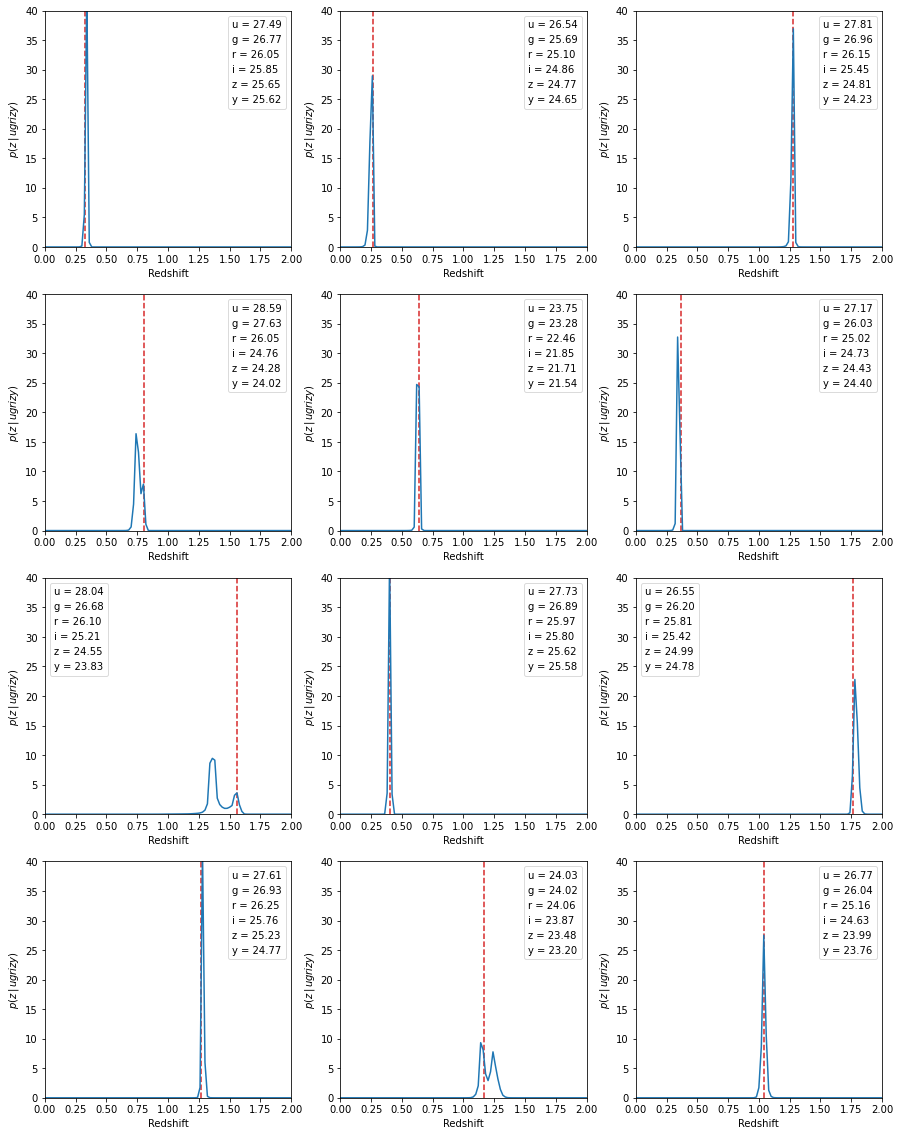

In [33]:
fig,axes = plt.subplots(4, 3, figsize=(15,20))

axes = axes.flatten()

for idx in range(len(axes)):
    
    zs = samples_wPDF.attrs['pdf_z']
    redshift,u,g,r,i,z,y,pz = samples_wPDF.loc[idx]
    axes[idx].plot(zs, pz)
    
    axes[idx].axvline(redshift, c='C3', ls='--', zorder=0)
    
    # create legend with magnitudes
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 6
    labels = []
    band_labels = ['u', 'g', 'r', 'i', 'z', 'y']
    for band,mag in zip(band_labels, [u,g,r,i,z,y]):
        labels.append(f'{band} = {mag:.2f}')
    axes[idx].legend(handles, labels, loc='best', 
              fancybox=True, framealpha=0.7, 
              handlelength=0, handletextpad=0)
    
    axes[idx].set_xlim(0,2)
    axes[idx].set_ylim(0,40)
    axes[idx].set_xlabel("Redshift")
    axes[idx].set_ylabel("$p(z \,|\, ugrizy)$")
    
fig.savefig('plots/conditional_prob_12.pdf')